# Retrieving the data and storing it

In [1]:
import lxml.html
from urllib.request import urlopen

# Nittany Lion Novice II
url = "http://www.hsquizbowl.org/db/tournaments/3799/stats/final/playerdetail/"
html = urlopen(url).read().decode("utf-8").replace("</tr>\r\n  <td ALIGN=LEFT>", "</tr>\r\n  <tr><td ALIGN=LEFT>")
tree = lxml.html.document_fromstring(html)

So we're going to `import` our HTML parser (`lxml.html`) and `urlopen()` from `urllib`.  
The HTML on the site is pretty broken so we have to do this funky replace to get it to work.  
Then we create the `tree`.

In [2]:
tablelist = tree.xpath(".//table")[1:]

The first `<table>` on the page is the navigation so we have to use `[1:]` to exclude it

In [3]:
class Player:
    def __init__(self, element):
        self.element = element
        self.header = element.getprevious().getprevious()
        self.name_link = self.header.getchildren()[0]
        self.team = self.name_link.tail[2:]
        self.name = self.name_link.text
        self.tablerows = self.element.findall('tr')
        self.load_games()

    def load_games(self):
        self.columns = [td.text_content() for td in self.tablerows[0].getchildren()]
        self.games = [self.make_dict(tr) for tr in self.tablerows[1:-1]]
        self.total = self.make_dict(self.tablerows[-1])
    
    def make_dict(self, tr):
        l = [td.text_content() for td in tr.getchildren()]
        d = {}
        for i in range(len(l)):
            d[self.columns[i]] = l[i]
        return d

playerlist = [Player(i) for i in tablelist]

Pretty basic stuff. We define a class `Player` with all the info from the tables.

## Plotting

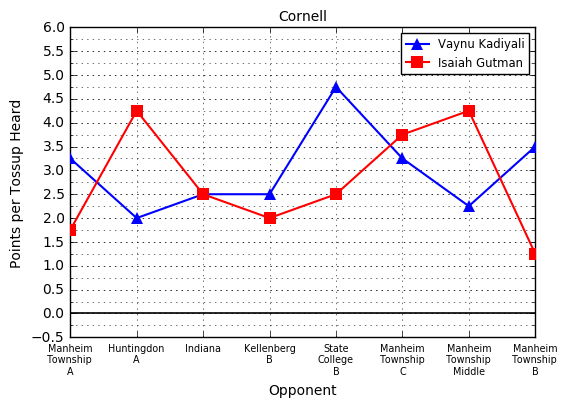

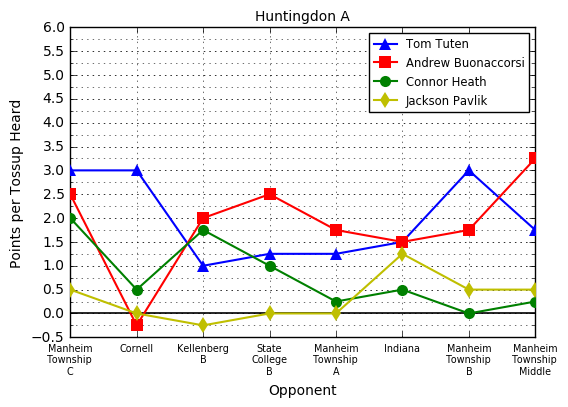

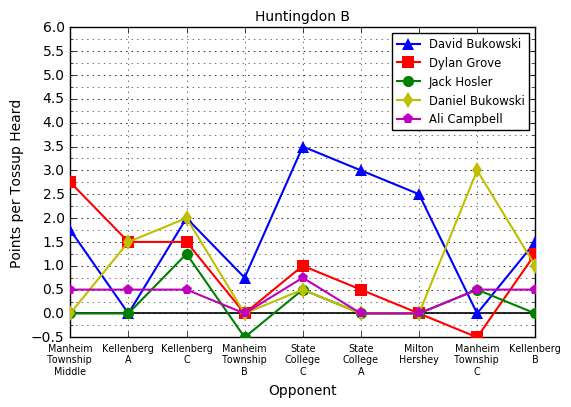

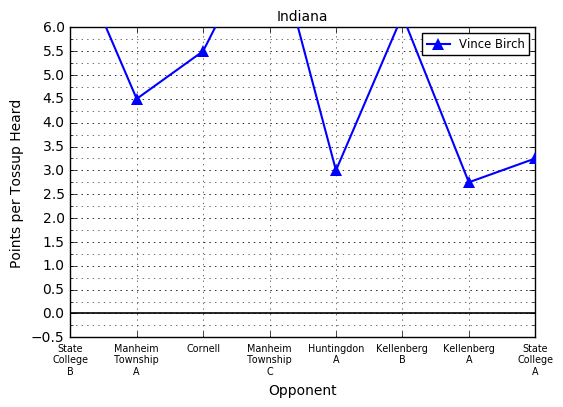

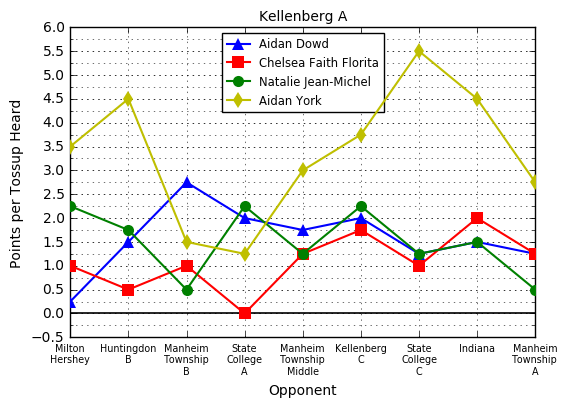

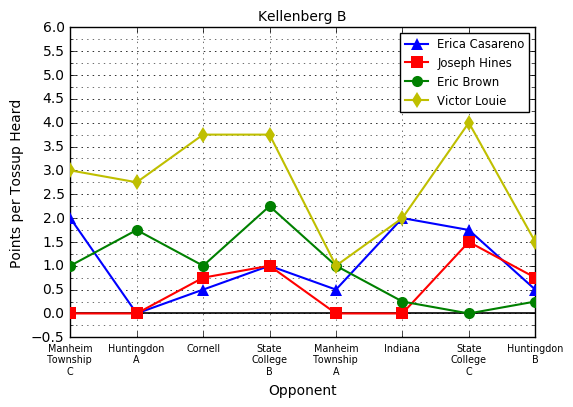

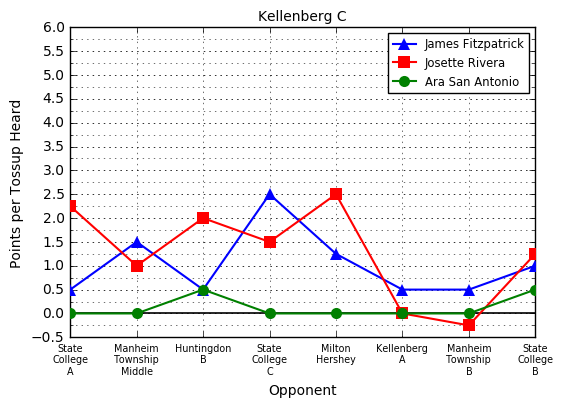

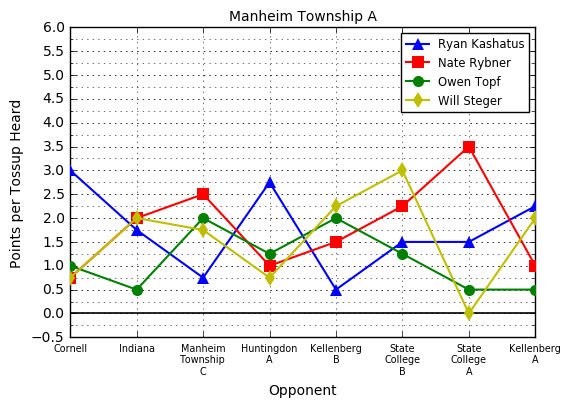

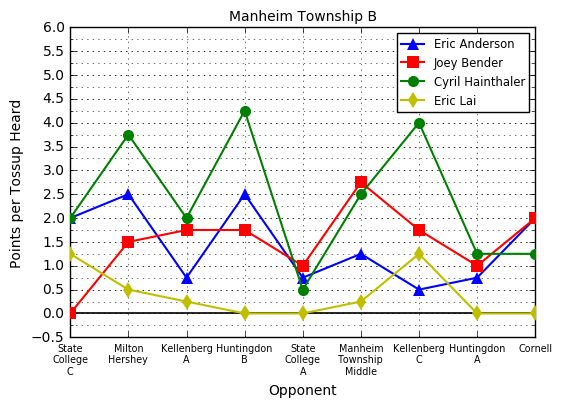

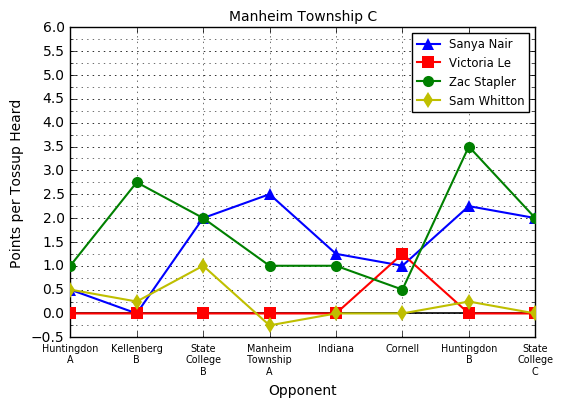

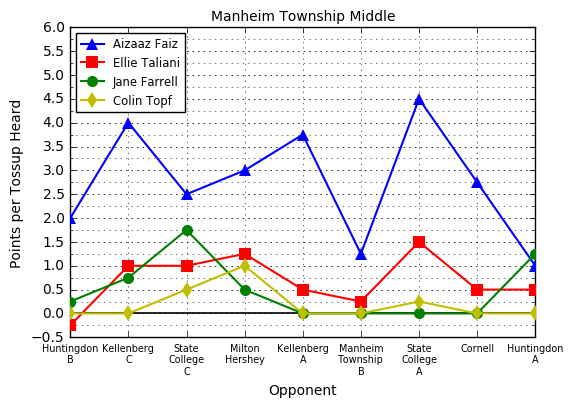

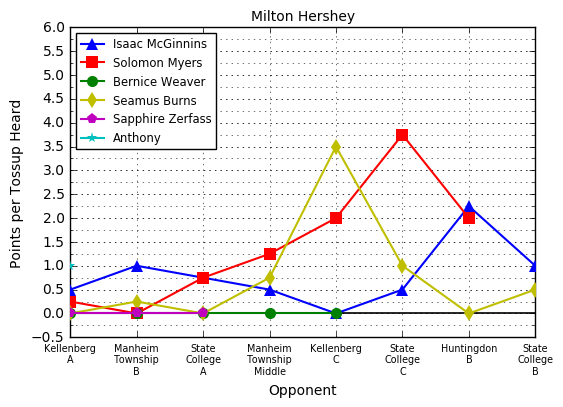

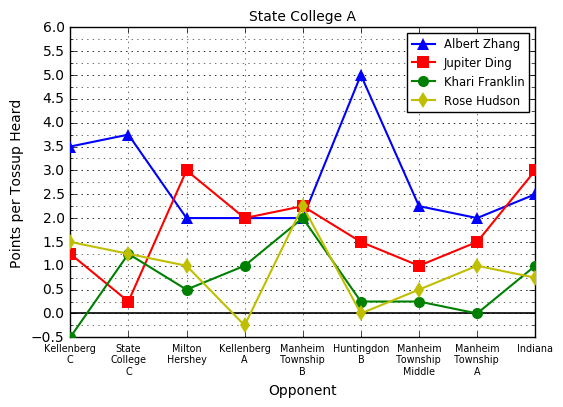

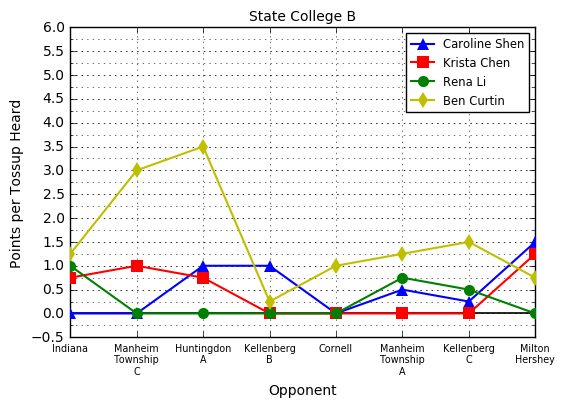

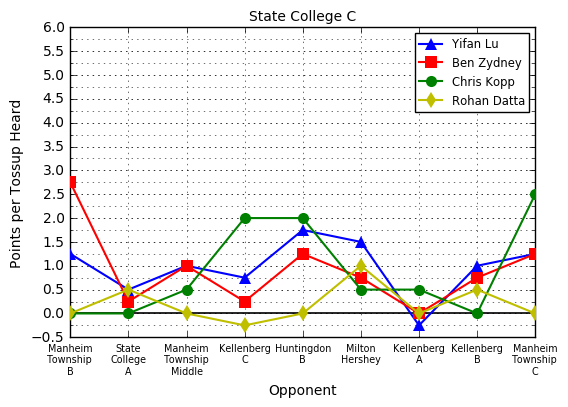

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from numpy import arange

%matplotlib inline

# Our Team
teams = sorted(set([i.team for i in playerlist]))
for team in teams:
    fig = plt.figure()
    players = [i for i in playerlist if i.team == team]
    
    points = [[game["P/TU"] for game in p.games] for p in players]

    ax = fig.add_subplot(111)

    ax.set_xlabel("Opponent")
    ax.set_ylabel("Points per Tossup Heard")
    ax.grid(which='both', alpha=0.8)
    ax.set_yticks(arange(-1, 6.5, 0.5))
    ax.set_yticks(arange(-1, 6.5, 0.25), minor=True)
    ax.set_xlim(0, len(points[0])-1)
    ax.set_ylim(-0.5, 6)
    ax.axhline(0, color='black', lw=1.2)

    styles = ['b^', 'rs', 'go', 'yd', 'mp', 'c*']
    for p in range(len(points)):
        ax.plot(points[p], styles[p] + "-", lw=1.5, markersize=8, markeredgecolor='none', label=players[p].name)

    for line in ax.get_lines():
        line.set_zorder(10)

    ax.legend(loc='best', fontsize='small', numpoints=1)

    ax.set_title(team, size="medium")

    ticks = ax.set_xticklabels([game["Opponent"].replace(" ", "\n") for game in players[0].games], size='x-small')

plt.savefig("ptu.png")